In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Mon Jan  2 15:58:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Set up

In [ ]:
'''
Download dữ liệu huấn luyện và kiểm thử từ google drive
'''
!gdown --id 1EowaITo5xCDFig91AHhOO_VrdIdM1gyb
!gdown --id 1D8jeiXmXr5vP8xC-pfTXvRKlFqvNUQUC

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1EowaITo5xCDFig91AHhOO_VrdIdM1gyb
To: /content/BTC-USD-test.csv
100% 42.6k/42.6k [00:00<00:00, 59.4MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1D8jeiXmXr5vP8xC-pfTXvRKlFqvNUQUC
To: /content/BTC-USD.csv
100% 194k/194k [00:00<00:00, 114MB/s]


In [ ]:
'''
Import 1 số thư viện cần thiết
'''
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
import os
import csv
import argparse
import tqdm
import gdown
import time
import matplotlib.pyplot as plt
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Convolution2D, Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
import keras.metrics as metrics
from keras.layers import AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.layers import BatchNormalization
from keras.layers import Dropout
from sklearn.metrics import classification_report
from keras.optimizers import Adam
import numpy as np
import tensorflow as tf
from keras import regularizers
from keras.layers import LeakyReLU
from sklearn.preprocessing import MinMaxScaler

# Tiền xử lí dữ liệu

In [ ]:
# Đọc dữ liệu huấn luyện
df = pd.read_csv('/content/BTC-USD.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/1/2015,320.434998,320.434998,314.002991,314.248993,314.248993,8.036550e+06
1,1/2/2015,314.079010,315.838989,313.565002,315.032013,315.032013,7.860650e+06
2,1/3/2015,314.846008,315.149994,281.082001,281.082001,281.082001,3.305440e+07
3,1/4/2015,281.145996,287.230011,257.612000,264.195007,264.195007,5.562910e+07
4,1/5/2015,265.084015,278.341003,265.084015,274.473999,274.473999,4.396280e+07
...,...,...,...,...,...,...,...
2453,9/19/2021,48268.855470,48328.367190,46919.804690,47260.218750,47260.218750,2.696772e+10
2454,9/20/2021,47261.406250,47328.199220,42598.914060,42843.800780,42843.800780,4.390985e+10
2455,9/21/2021,43012.234380,43607.609380,39787.609380,40693.675780,40693.675780,4.870109e+10
2456,9/22/2021,40677.953130,43978.621090,40625.632810,43574.507810,43574.507810,3.813971e+10


In [ ]:
'''
Chia tập train và tập validation dựa trên bộ dữ liệu đã đọc ở trên
'''
# Chia tập train với tỉ lệ là 80%
num_train_proportion = 0.8
# Lấy kích cỡ dữ liệu đọc được: 2458 rows × 7 columns
(num_row, num_column) = df.shape
# Lây tỷ lệ chia tập train nhân với số lượng datasets (số hàng)
num_train = int(num_train_proportion * df.shape[0])
print('Number of trains: ',num_train)
# Tính số lượng tập validation
num_valid = num_row - num_train
print('Number of validations: ', num_valid)
print('Total: ', num_train + num_valid)

Number of trains:  1966
Number of validations:  492
Total:  2458


In [ ]:
# Lấy dữ liệu đã chia theo tỷ lệ ở trên
training_set = df.iloc[:num_train, 4:5].values
validation_set = df.iloc[num_train:, 4:5].values
# Scale dữ liệu về khoảng [-1, 2]
sc = MinMaxScaler(feature_range=(-2, 2))
training_set_scaled = sc.fit_transform(training_set)
validation_set_scaled = sc.fit_transform(validation_set)
print('Shape of training datasets:', training_set_scaled.shape)
print('Shape of testing datasetes: ', validation_set_scaled.shape)

Shape of training datasets: (1966, 1)
Shape of testing datasetes:  (492, 1)


In [ ]:
# nun_steps: số ngõ vào, tức là bao nhiêu ngõ vào sẽ dữ đoán 1 output
num_steps = 5
'''
Chia tập dữ liệu với num_steps:
+ X_train: dữ liệu để train
+ y_train: dữ liệu kiểm thử X_train
+ X_val: dữ liệu để test trong quá trình training
+ y_val: dữ liệu kiểm thử X_val
'''
X_train = []
y_train = []
X_val = []
y_val = []
for i in range(num_steps, num_train):
    X_train.append(training_set_scaled[i - num_steps:i, 0])
    # training_set_scaled[i, 0] = 1
    y_train.append(training_set_scaled[i, 0])
for j in range(num_steps, num_valid):
    X_val.append(validation_set_scaled[j - num_steps:j, 0])
    # validation_set_scaled[j, 0] = 1
    y_val.append(validation_set_scaled[j, 0])
X_train, y_train = np.array(X_train), np.array(y_train).reshape(len(y_train), 1)
# y_train = to_categorical(np.argmax(y_train, axis=1), y_train.shape[1])
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val, y_val = np.array(X_val), np.array(y_val).reshape(len(y_val), 1)
# y_val = to_categorical(np.argmax(y_val, axis=1), y_val.shape[1])
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
'''
(1964, 2, 1): 
+ 1964: số lượng tập train
+ 2: số ngõ vào
+ 1: số ngõ ra do chỉ dụ đoán Close 
(490, 2, 1):
+ 490: số lượng tập validation
+ 2: số ngõ vào
+ 1: số ngõ ra do chỉ dụ đoán Close
'''
print('Training datasets shape: ', X_train.shape, y_train.shape)
print('Validating datasets shape: ', X_val.shape, y_val.shape)

Training datasets shape:  (1961, 5, 1) (1961, 1)
Validating datasets shape:  (487, 5, 1) (487, 1)


# Xây dựng mô hình deep learning

In [ ]:
class AttenLayer(tf.keras.layers.Layer):
    """
    Attention Layers used to Compute Weighted Features along Time axis
    Args:
        num_state :  number of hidden Attention state

    edited code provided on https://github.com/ludlows
    """

    def __init__(self, num_state, **kw):
        super(AttenLayer, self).__init__(**kw)
        self.prob_kernel = None
        self.bias = None
        self.kernel = None
        self.num_state = num_state

    def build(self, input_shape):
        self.kernel = self.add_weight('kernel', shape=[input_shape[-1], self.num_state])
        self.bias = self.add_weight('bias', shape=[self.num_state])
        self.prob_kernel = self.add_weight('prob_kernel', shape=[self.num_state])

    def call(self, input_tensor, **kwargs):
        atten_state = tf.tanh(tf.tensordot(input_tensor, self.kernel, axes=1) + self.bias)
        logits = tf.tensordot(atten_state, self.prob_kernel, axes=1)
        prob = tf.nn.softmax(logits)
        weighted_feature = tf.reduce_sum(tf.multiply(input_tensor, tf.expand_dims(prob, -1)), axis=1)
        return weighted_feature

    # for saving the model
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_state': self.num_state, })
        return config
def ReshapeLayer(x):
    
    shape = x.shape
    
    # 1 possibility: H,W*channel
    reshape = tf.keras.layers.Reshape((shape[1],shape[2]*shape[3]))(x)
    
    # 2 possibility: W,H*channel
    # transpose = Permute((2,1,3))(x)
    # reshape = Reshape((shape[1],shape[2]*shape[3]))(transpose)
    
    return reshape

# Xây dựng mô hình Bidirectional LSTM + Attention Layer
def build_model_BiLSTM(num_input, num_output):
  x_in = tf.keras.Input(shape=(num_input, 1))
  x_tensor = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=30, return_sequences=True))(x_in)
  x_tensor = tf.keras.layers.Dropout(0.5)(x_tensor)
  x_tensor = AttenLayer(20)(x_tensor)
  x_tensor = tf.keras.layers.Dropout(0.2)(x_tensor)
  pred = tf.keras.layers.Dense(num_output, activation='leaky_relu')(x_tensor)
  model = tf.keras.Model(inputs=x_in, outputs=pred)
  return model
#Xây dựng mô hình CNN2D
def build_model_CNN2D(shape_input, num_output):
  model = Sequential()
  model.add(Conv2D(32, 3, 3, input_shape=(shape_input[1], shape_input[-1], 1), padding='same', use_bias=True))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, 3, 3, padding='same', use_bias=True))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
  model.add(Flatten())
  model.add(Dense(128, activation='leaky_relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='leaky_relu'))
  model.add(Dropout(0.2))
  model.add(Dense(num_output, activation='leaky_relu'))
  return model
# Xây dựng mô hình CNN2D + Bidirectional LSTM
def build_model_CNN_BiLSTM(shape_input, num_output):
  model = Sequential()
  model.add(Conv2D(32, 3, 3, input_shape=(shape_input[1], shape_input[-1], 1), padding='same', use_bias=True))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, 3, 3, padding='same', use_bias=True))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
  # model.add(tf.keras.layers.Flatten())
  # model.add(tf.keras.Input(shape=(shape_input[1], 1)))
  model.add(tf.keras.layers.Lambda(ReshapeLayer))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=30, return_sequences=True)))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(AttenLayer(20))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(num_output, activation='leaky_relu'))
  #model.add(tf.keras.Model(inputs=tf.keras.Input(shape=(shape_input[1], 1), outputs=tf.keras.layers.Dense(num_output, activation='leaky_relu'))))
  return model

# Huấn luyện

# Model BiLSTM

In [ ]:
# Huấn luyện mô hình BiLSTM
'''
Batch size: 64
Epochs: 200
Loss: Mean square error
Learning rate: 0.0001
'''

modelBiLSTM = build_model_BiLSTM(num_input=5, num_output=1)
modelBiLSTM.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['accuracy'])
modelBiLSTM.summary()
historyBiLSTM = modelBiLSTM.fit(
    X_train,
    y_train,
    batch_size=64, epochs=300,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('best_attend_BiLSTM.hdf5',
                                            monitor='val_accuracy',
                                            save_best_only=True,
                                            save_weights_only=False,
                                            mode='auto')
    ])
modelBiLSTM.save_weights('best_attend_BiLSTM.hdf5')

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5, 1)]            0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 5, 60)            7680      
 nal)                                                            
                                                                 
 dropout_38 (Dropout)        (None, 5, 60)             0         
                                                                 
 atten_layer_9 (AttenLayer)  (None, 60)                1240      
                                                                 
 dropout_39 (Dropout)        (None, 60)                0         
                                                                 
 dense_24 (Dense)            (None, 1)                 61        
                                                           

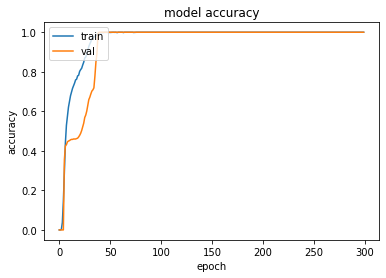

In [ ]:
accuracy = historyBiLSTM.history['accuracy']
val_accuracy = historyBiLSTM.history['val_accuracy']
plt.plot(historyBiLSTM.history['accuracy'])
plt.plot(historyBiLSTM.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('model_accuracy.png')
plt.show()

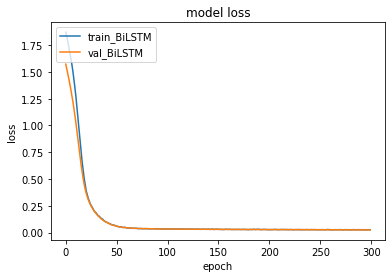

In [ ]:
# Vẽ đồ thị so sánh 3 model huấn luyện
plt.plot(historyBiLSTM.history['loss'])
plt.plot(historyBiLSTM.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_BiLSTM', 'val_BiLSTM'], loc='upper left')
plt.savefig('/content/model_loss.png')
plt.show()

# Mô hình CNN2D 

In [ ]:
# Huấn luyện mô hình CNN2D
'''
Batch size: 64
Epochs: 200
Loss: Mean square error
Learning rate: 0.0001
'''
modelCNN2D = build_model_CNN2D(shape_input=X_train.shape, num_output=X_train.shape[-1])
modelCNN2D.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['accuracy'])
modelCNN2D.summary()
historyCNN2D = modelCNN2D.fit(
    tf.expand_dims(X_train, axis=-1),
    y_train,
    batch_size=64, epochs=300,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('best_attend_CNN2D.hdf5',
                                            monitor='val_accuracy',
                                            save_best_only=True,
                                            save_weights_only=False)
    ])
modelCNN2D.save_weights('best_attend_CNN2D.hdf5')

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 2, 1, 32)          320       
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 2, 1, 32)          0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 1, 1, 32)         0         
 g2D)                                                            
                                                                 
 dropout_33 (Dropout)        (None, 1, 1, 32)          0         
                                                                 
 conv2d_19 (Conv2D)          (None, 1, 1, 64)          18496     
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 1, 1, 64)          0         
                                                      

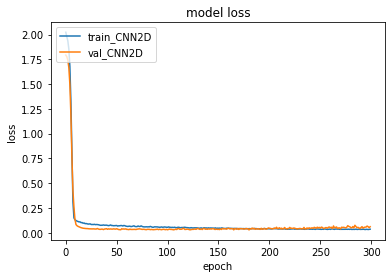

In [ ]:
plt.plot(historyCNN2D.history['loss'])
plt.plot(historyCNN2D.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_CNN2D', 'val_CNN2D'], loc='upper left')
plt.savefig('/content/model_loss.png')
plt.show()

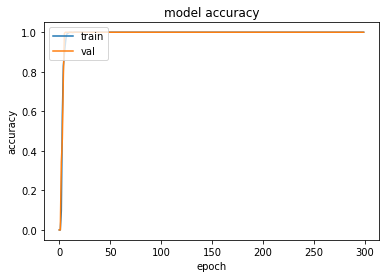

In [ ]:
accuracy = historyCNN2D.history['accuracy']
val_accuracy = historyCNN2D.history['val_accuracy']
plt.plot(historyCNN2D.history['accuracy'])
plt.plot(historyCNN2D.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('model_accuracy.png')
plt.show()

# CNN2D + BiLSTM

In [ ]:
# Huấn luyện mô hình CNN2D + BiLSTM
'''
Batch size: 64
Epochs: 200
Loss: Mean square error
Learning rate: 0.0001
'''
modelCNN_BiLSTM = build_model_CNN_BiLSTM(shape_input=X_train.shape, num_output=X_train.shape[-1])
modelCNN_BiLSTM.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['accuracy'])
modelCNN_BiLSTM.summary()
historyCNN_BiLSTM = modelCNN_BiLSTM.fit(
    tf.expand_dims(X_train, axis=-1),
    y_train,
    batch_size=64, epochs=300,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('best_attend_CNN_BiLSTM.hdf5',
                                            monitor='val_accuracy',
                                            save_best_only=True,
                                            save_weights_only=False)
    ])
modelCNN_BiLSTM.save_weights('best_attend_CNN_BiLSTM.hdf5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 2, 1, 32)          320       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 2, 1, 32)          0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 32)         0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 1, 1, 32)          0         
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 1, 64)          18496     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1, 1, 64)          0         
                                                      

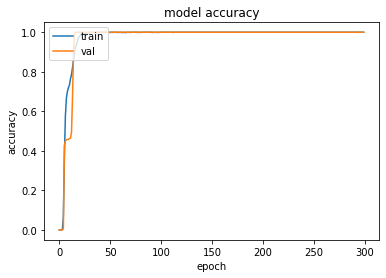

In [ ]:
accuracy = historyCNN_BiLSTM.history['accuracy']
val_accuracy = historyCNN_BiLSTM.history['val_accuracy']
plt.plot(historyCNN_BiLSTM.history['accuracy'])
plt.plot(historyCNN_BiLSTM.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('model_accuracy.png')
plt.show()

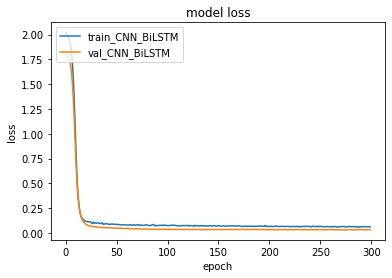

In [ ]:
plt.plot(historyCNN_BiLSTM.history['loss'])
plt.plot(historyCNN_BiLSTM.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_CNN_BiLSTM', 'val_CNN_BiLSTM'], loc='upper left')
plt.savefig('/content/model_loss.png')
plt.show()

# Load tập test

In [ ]:
# Đọc dữ liệu tập test
df_test = pd.read_csv('/content/BTC-USD-test.csv')
df_test

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-25,8786.107422,8951.005859,8719.667969,8906.934570,8906.934570,31288157264
1,2020-05-26,8909.585938,8991.967773,8757.293945,8835.052734,8835.052734,29584186947
2,2020-05-27,8837.380859,9203.320313,8834.157227,9181.017578,9181.017578,32740536902
3,2020-05-28,9184.945313,9546.319336,9148.457031,9525.750977,9525.750977,34367073114
4,2020-05-29,9528.355469,9573.666992,9379.338867,9439.124023,9439.124023,32896642044
...,...,...,...,...,...,...,...
482,2021-09-19,48268.855469,48328.367188,46919.804688,47260.218750,47260.218750,26967722648
483,2021-09-20,47261.406250,47328.199219,42598.914063,42843.800781,42843.800781,43909845642
484,2021-09-21,43012.234375,43607.609375,39787.609375,40693.675781,40693.675781,48701090088
485,2021-09-22,40677.953125,43978.621094,40625.632813,43574.507813,43574.507813,38139709246


In [ ]:
# Lấy giá trị cột CLose
testing_set = df_test.filter(['Close']).values
testing_set = testing_set.reshape(-1,1)
sc = MinMaxScaler(feature_range=(-2, 2))
testing_set = sc.fit_transform(testing_set)
X_test = []
for i in range(num_steps, testing_set.shape[0]):
    X_test.append(testing_set[i - num_steps:i, :])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
'''
(485, 2, 1):
+ 485: số lượng dữ liệu tập test
+ 2: số ngõ vào
+ 1: số ngõ ra
'''
print('Testing shape: ', X_test.shape)

Testing shape:  (482, 5, 1)


# Load model đã train và test

# Load model BiLSTM

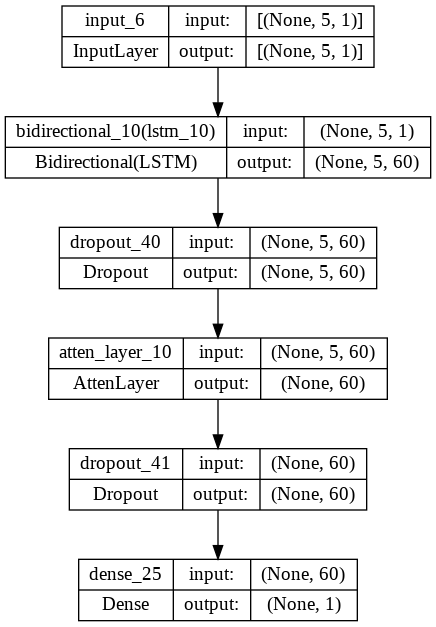

In [ ]:
modelBiLSTM = build_model_BiLSTM(num_input=5, num_output=1)
plot_model(modelBiLSTM, to_file='modelBiLSTM.png', show_shapes=True, show_layer_names=True)

In [ ]:
# True: nếu muốn load weight đã train, False: load weight train ở trên
LOAD_WEIGHT = True
if not os.path.exists('/content/pretrained/'):
  os.makedirs('/content/pretrained')

In [ ]:
# File trọng số BiLSTM sau khi huấn luyện
hdf5path_BiLSTM = 'best_attend_BiLSTM.hdf5'
# Load model BiLSTM sau khi huấn luyện
start_BiLSTM = time.time()
if LOAD_WEIGHT:
  hdf5path_BiLSTM = gdown.download(id='1Ncz2s0wM8txgPPeHtAio2CIkQFdS1fYw', output='/content/pretrained/' + hdf5path_BiLSTM, quiet=False)
modelBiLSTM.load_weights(hdf5path_BiLSTM)
y_test_BiLSTM = modelBiLSTM.predict(X_test)
print('Inference time of BiLSTM: {:.2f} s'.format(time.time() - start_BiLSTM))

Downloading...
From: https://drive.google.com/uc?id=1Ncz2s0wM8txgPPeHtAio2CIkQFdS1fYw
To: /content/pretrained/best_attend_BiLSTM.hdf5
100%|██████████| 60.7k/60.7k [00:00<00:00, 24.1MB/s]


16/16 [==============================] - 1s 3ms/step
Inference time of BiLSTM: 1.14 s


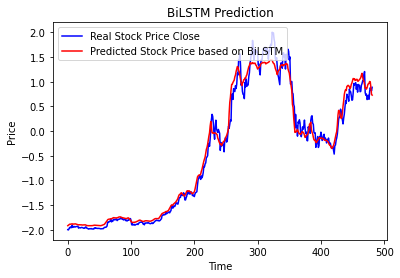

In [ ]:
plt.plot(testing_set, 'b-', label='Real Stock Price Close')
# plt.plot(y_test_CNN, 'r-', label='Predicted Stock Price based on CNN')
plt.plot(y_test_BiLSTM, 'r-', label='Predicted Stock Price based on BiLSTM')
# plt.plot(y_test_BiLSTM_CNN, 'r-', label='Predicted Stock Price base on combination between CNN and BiLSTM')
plt.title('BiLSTM Prediction')
plt.savefig('model_prediction.png')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()

# Load model CNN2D

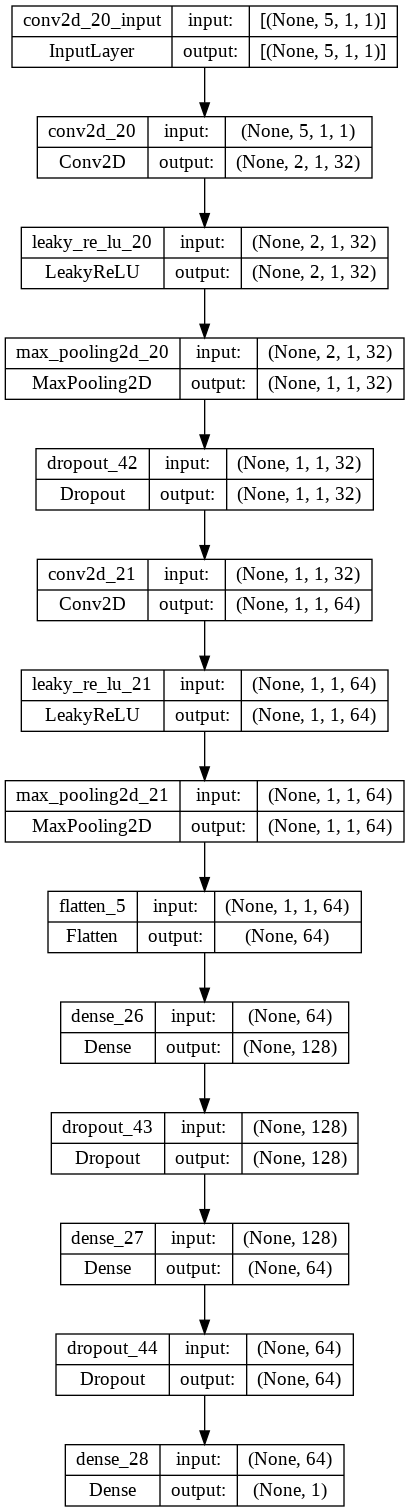

In [ ]:
modelCNN2D = build_model_CNN2D(shape_input=X_train.shape, num_output=X_train.shape[-1])
plot_model(modelCNN2D, to_file='modelCNN2D.png', show_shapes=True, show_layer_names=True)

In [ ]:
# True: nếu muốn load weight đã train, False: load weight train ở trên
LOAD_WEIGHT = True

In [ ]:
# File trọng số CNN2D sau khi huấn luyện
hdf5path_CNN2D= 'best_attend_CNN2D.hdf5'
if LOAD_WEIGHT:
  hdf5path_CNN2D = gdown.download(id='1sapynWP0RgtrR1aVC1GNIJO0_KQwABn-', output='/content/pretrained/' + hdf5path_CNN2D, quiet=False)
# Load model CNN2D sau khi huấn luyện
start = time.time()
modelCNN2D.load_weights(hdf5path_CNN2D)
y_test_CNN2D = modelCNN2D.predict(X_test)
print('Inference time of CNN2D: {:.2f} s'.format(time.time() - start))

Downloading...
From: https://drive.google.com/uc?id=1sapynWP0RgtrR1aVC1GNIJO0_KQwABn-
To: /content/pretrained/best_attend_CNN2D.hdf5
100%|██████████| 171k/171k [00:00<00:00, 82.4MB/s]

16/16 [==============================] - 0s 2ms/step
Inference time of CNN2D: 0.14 s


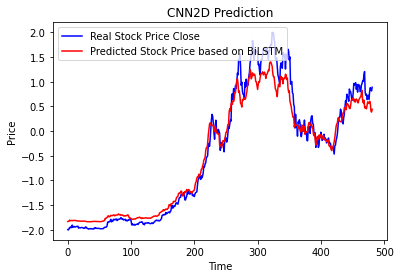

In [ ]:
plt.plot(testing_set, 'b-', label='Real Stock Price Close')
# plt.plot(y_test_CNN, 'r-', label='Predicted Stock Price based on CNN')
plt.plot(y_test_CNN2D, 'r-', label='Predicted Stock Price based on BiLSTM')
# plt.plot(y_test_BiLSTM_CNN, 'r-', label='Predicted Stock Price base on combination between CNN and BiLSTM')
plt.title('CNN2D Prediction')
plt.savefig('model_prediction.png')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

# Load model CNN2D + BiLSTM

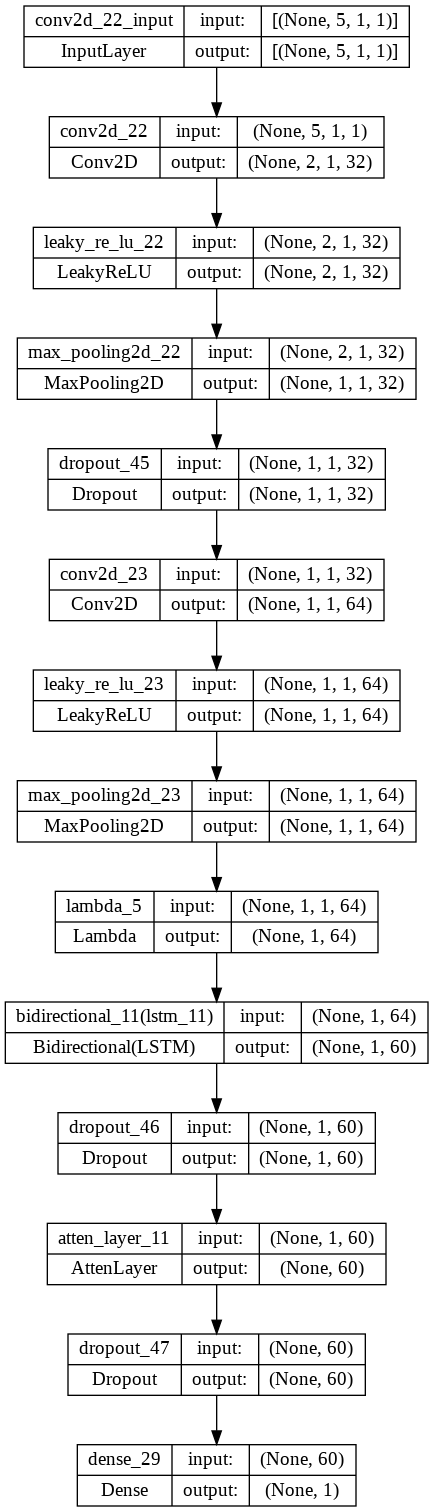

In [ ]:
modelCNN_BiLSTM = build_model_CNN_BiLSTM(shape_input=X_train.shape, num_output=X_train.shape[-1])
plot_model(modelCNN_BiLSTM, to_file='modelCNN2D_BiLSTM.png', show_shapes=True, show_layer_names=True)

In [ ]:
# True: nếu muốn load weight đã train, False: load weight train ở trên
LOAD_WEIGHT = True

In [ ]:
# File trọng số CNN2D + BiLSTM sau khi huấn luyện
hdf5path_CNN_BiLSTM = 'best_attend_CNN_BiLSTM.hdf5'
# Load model CNN2D + BiLSTM sau khi huấn luyện
if LOAD_WEIGHT:
  hdf5path_CNN_BiLSTM = gdown.download(id='1vQn7zzVsh2cXOQ5CngwRdToxWBQs1I9H', output='/content/pretrained/' + hdf5path_CNN_BiLSTM, quiet=False)
start = time.time()
modelCNN_BiLSTM.load_weights(hdf5path_CNN_BiLSTM)
y_test_CNN_BiLSTM = modelCNN_BiLSTM.predict(X_test)
print('Inference time of CNN2D and BiLSTM: {:.2f} s'.format(time.time() - start))

Downloading...
From: https://drive.google.com/uc?id=1vQn7zzVsh2cXOQ5CngwRdToxWBQs1I9H
To: /content/pretrained/best_attend_CNN_BiLSTM.hdf5
100%|██████████| 206k/206k [00:00<00:00, 57.4MB/s]


16/16 [==============================] - 1s 3ms/step
Inference time of CNN2D and BiLSTM: 0.86 s


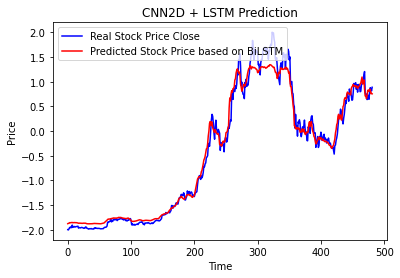

In [ ]:
plt.plot(testing_set, 'b-', label='Real Stock Price Close')
# plt.plot(y_test_CNN, 'r-', label='Predicted Stock Price based on CNN')
plt.plot(y_test_CNN_BiLSTM, 'r-', label='Predicted Stock Price based on BiLSTM')
# plt.plot(y_test_BiLSTM_CNN, 'r-', label='Predicted Stock Price base on combination between CNN and BiLSTM')
plt.title('CNN2D + LSTM Prediction')
plt.savefig('model_prediction.png')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

# Tính RMSE, MSE, MAE VÀ R2-SCORE

In [ ]:
# Model BiLSTM
import sklearn.metrics as metrics

testing_set = np.asarray(testing_set[:482])
y_test_BiLSTM = np.asarray(y_test_BiLSTM)

mae = metrics.mean_absolute_error(y_test_BiLSTM.reshape(-1,1), testing_set)
mse = metrics.mean_squared_error(y_test_BiLSTM.reshape(-1,1), testing_set)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(y_test_BiLSTM.reshape(-1,1),testing_set)

print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

MAE: 0.12315954001353377
MSE: 0.027457008632092342
RMSE: 0.1657015649657309
R-Squared: 0.9819659509706127


In [ ]:
# Model CNN2D
import sklearn.metrics as metrics

testing_set = np.asarray(testing_set[:482])
y_test_CNN2D = np.asarray(y_test_CNN2D)

mae = metrics.mean_absolute_error(y_test_CNN2D.reshape(-1,1), testing_set)
mse = metrics.mean_squared_error(y_test_CNN2D.reshape(-1,1), testing_set)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(y_test_CNN2D.reshape(-1,1),testing_set)

print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

MAE: 0.18378829011715092
MSE: 0.06284281816973358
RMSE: 0.25068469871480703
R-Squared: 0.9474461014628257


In [ ]:
# Model CNN2D + BiLSTM
import sklearn.metrics as metrics

testing_set = np.asarray(testing_set[:482])
y_test_CNN_BiLSTM = np.asarray(y_test_CNN_BiLSTM)

mae = metrics.mean_absolute_error(y_test_CNN_BiLSTM.reshape(-1,1), testing_set)
mse = metrics.mean_squared_error(y_test_CNN_BiLSTM.reshape(-1,1), testing_set)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(y_test_CNN_BiLSTM.reshape(-1,1),testing_set)

print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

MAE: 0.1201211104421773
MSE: 0.02836242632983559
RMSE: 0.16841147921040178
R-Squared: 0.9804064252159527
